Fuente : https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Dataset

In [3]:
toxic_comments = pd.read_csv("./dataset/train.csv")

In [4]:
print(toxic_comments.shape)

toxic_comments.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [6]:
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [7]:
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [8]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


<AxesSubplot:>

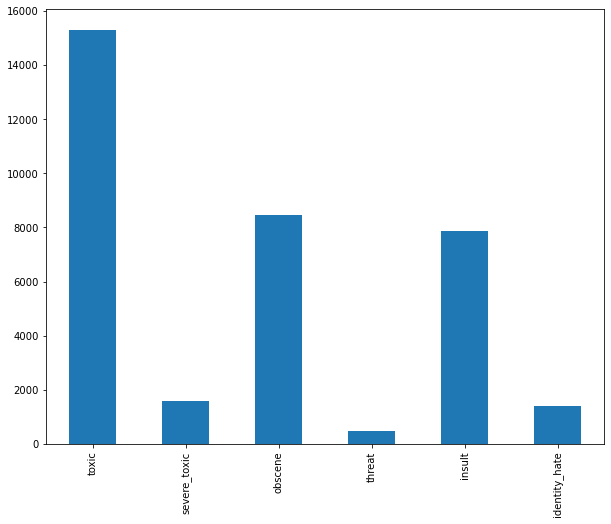

In [9]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

# Modelo

In [10]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [11]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#### Embedding Glove

In [16]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('./dataset/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


#### Entreno

In [19]:
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = "./mejor_modelo.h5"

callback1 = (
    filepath = checkpoint_filepath, 
    monitor='val_acc', 
    save_best_only=False,
    save_weights_only=True, 
    mode='max'
)

history = model.fit(X_train, y_train.astype(int), batch_size=128, epochs=5, verbose=1, validation_split=0.2, callbacks=[callback1])

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 210s 2ms/step - loss: 0.1221 - acc: 0.9667 - val_loss: 0.0781 - val_acc: 0.9763
Epoch 2/5
102124/102124 [==============================] - 202s 2ms/step - loss: 0.0668 - acc: 0.9778 - val_loss: 0.0677 - val_acc: 0.9781
Epoch 3/5
102124/102124 [==============================] - 200s 2ms/step - loss: 0.0607 - acc: 0.9793 - val_loss: 0.0600 - val_acc: 0.9795
Epoch 4/5
102124/102124 [==============================] - 200s 2ms/step - loss: 0.0577 - acc: 0.9800 - val_loss: 0.0577 - val_acc: 0.9799
Epoch 5/5
102124/102124 [==============================] - 216s 2ms/step - loss: 0.0554 - acc: 0.9808 - val_loss: 0.0560 - val_acc: 0.9804


In [ ]:
#Cargamos la mejor epoca del modelo
model.load_weights(checkpoint_filepath)

In [20]:
score = model.evaluate(X_test, y_test.astype(int), verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 51s 2ms/step
Test Score: 0.05458501485491105
Test Accuracy: 0.9806464910507202


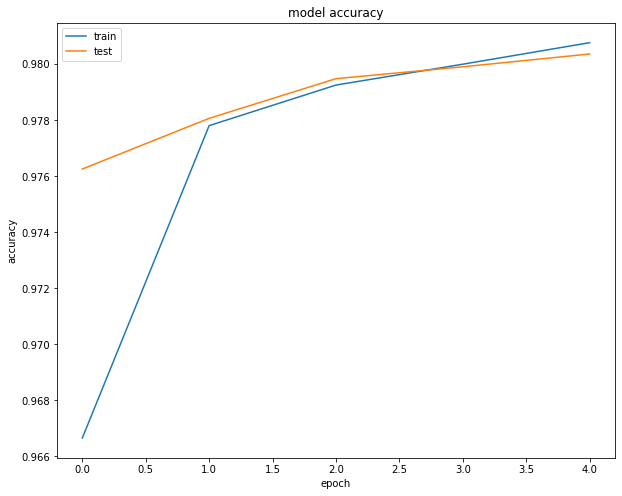

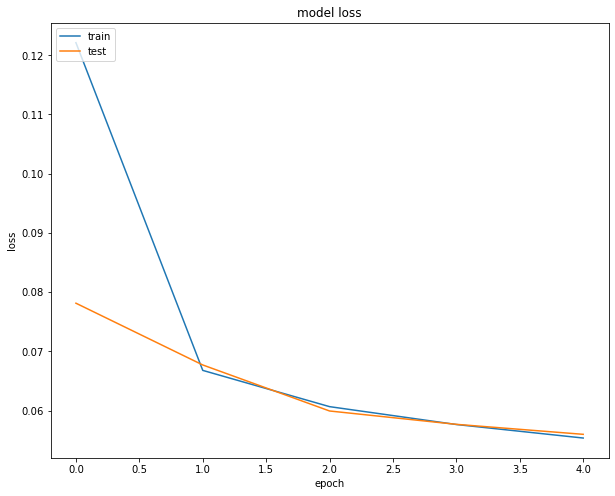

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model.save("multilabel_clasification_model.h5")

## Prediccion

In [23]:
X2 = tokenizer.texts_to_sequences(['my evil comment'])
X2 = pad_sequences(X2, padding='post', maxlen=maxlen)
#you must reoder the labls in alphabetical order (keras)
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
pred = model.predict(X2)
for i, p in enumerate(pred[0]):
    print(labels[i], ":", p)

toxic : 0.2948024
severe_toxic : 0.0032631753
obscene : 0.054860324
threat : 0.0061748563
insult : 0.07765108
identity_hate : 0.013025363
